# Lab 5: Species Distribution Modeling with Bagging 
Climate change and deforestation are accelerating ecosystem degradation, pushing animal species toward the brink of extinction. Understanding the distribution of animals and the factors that influence their ability to thrive in different environments is critical for conservation efforts. By studying these relationships, biological conservationists can develop informed strategies to protect endangered species and maintain biodiversity across diverse ecosystems.

Species are defined by their behavioral, physiological, and ecological attributes, which shape their roles in ecosystems. In turn, ecosystems and their functions are deeply influenced by the species that inhabit them. This reciprocal relationship makes evaluating species' functional diversity and distributions essential for research in biogeography, community ecology, macroevolution, and conservation. Functional diversity is determined by traits such as diet, foraging strata, trophic level, activity cycle, litter size, generation length, habitat breadth, and body mass. These traits influence an animal’s ability to survive and adapt to different climates, playing a crucial role in ecosystem stability.

In this lab, we will explore the connections between animal behaviors, functional traits, and species distributions across different climates.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.utils import resample, shuffle
import numpy as np

### Step 1: Standardizing column names

The dataset contains several columns that describe different aspects of bird diets. These column names currently include spaces, colons (:), and special characters, which can make them difficult to work with in code.

Load the dataset (BirdTraitData.csv) into a Pandas DataFrame.

The 7 column names that start with "Diet:" should be renamed to simpler version starting with `Diet_` in a way that conforms with this list of key variables:

`AdultBodyMass`, `DietBreadth`, `Diet_Invertebrates`, `Diet_Vertebrates`,`Diet_Fruits`, `Diet_Flowers`, `Diet_Seeds`, `Diet_Plants`, `Diet_Other`, `TrophicLevel`,`ActivityCycle`, `ForagingStratum`, `MigratoryStatus`,`IncubationTime`, `ClutchSize`, `EggLength`, `EggWidth`,`EggMass`, `NestingHabit`,`MaxLongevity`, `Subarid`

Then select only that list of 21 key variables. **Print the head of your dataframe.** 

In [2]:
bird_traits = pd.read_csv('/Users/jpcohen/MEDS/eds_232/EDS232-labs/Week5/BirdTraitData.csv', encoding = 'cp1252')

bird_traits_select = (
    
    # rename columns
    bird_traits.rename(columns = {
    'AdultBodyMass': 'AdultBodyMass', 
    'DietBreadth': 'DietBreadth', 
    'Diet: invertebrates': 'Diet_Invertebrates',
    'Diet: vertebrates': 'Diet_Vertebrates', 
    'Diet: fruits': 'Diet_Fruits', 
    'Diet: flower/nectar/pollen/gums': 'Diet_Flowers', 
    'Diet: seeds': 'Diet_Seeds', 
    'Diet: other plant materials': 'Diet_Plants', 
    'Diet: scavenge; garbage; carrion; offal; carcasses': 'Diet_Other', 
    'TrophicLevel': 'TrophicLevel', 
    'ActivityCycle': 'ActivityCycle', 
    'ForagingStratum': 'ForagingStratum', 
    'MigratoryStatus': 'MigratoryStatus', 
    'IncubationTime': 'IncubationTime',
    'ClutchSize': 'ClutchSize', 
    'EggLength': 'EggLength', 
    'EggWidth': 'EggWidth', 
    'EggMass': 'EggMass', 
    'NestingHabit': 'NestingHabit',
    'MaxLongevity': 'MaxLongevity', 
    'Subarid': 'Subarid'}
    )
                
    # select columns
    [['AdultBodyMass', 
      'DietBreadth', 
      'Diet_Invertebrates', 
      'Diet_Vertebrates', 
      'Diet_Fruits', 
      'Diet_Flowers', 
      'Diet_Seeds', 
      'Diet_Plants', 
      'Diet_Other', 
      'TrophicLevel', 
      'ActivityCycle', 
      'ForagingStratum', 
      'MigratoryStatus', 
      'IncubationTime', 
      'ClutchSize', 
      'EggLength', 
      'EggWidth', 
      'EggMass', 
      'NestingHabit', 
      'MaxLongevity', 
      'Subarid'
     ]]
                     )

bird_traits_select.head()

,AdultBodyMass,DietBreadth,Diet_Invertebrates,Diet_Vertebrates,Diet_Fruits,Diet_Flowers,Diet_Seeds,Diet_Plants,Diet_Other,TrophicLevel,...,ForagingStratum,MigratoryStatus,IncubationTime,ClutchSize,EggLength,EggWidth,EggMass,NestingHabit,MaxLongevity,Subarid
0,138.5,2,yes,yes,no,no,no,no,no,3,...,3,no,31.0,3.0,3.85,-999.00,-999.0,arboreal,-999.0,1
1,1050.0,1,no,yes,no,no,no,no,no,3,...,3,no,39.5,2.5,58.50,46.95,-999.0,arboreal,-999.0,1
2,181.0,2,yes,yes,no,no,no,no,no,3,...,3,no,35.0,2.5,38.35,31.90,-999.0,arboreal,-999.0,1
3,292.0,2,yes,yes,no,no,no,no,no,3,...,3,no,31.0,1.5,43.70,35.20,29.1,arboreal,-999.0,1
4,511.0,2,yes,yes,no,no,no,no,no,3,...,4,no,35.5,2.0,54.50,45.00,-999.0,arboreal,144.0,1


### Step 2: Encode categorical variables
In our dataset, some columns contain categorical (non-numeric) data, such as species names or habitat types that need to be converted to numerical representations. Let's use label encoding to assign a unique number to each category in a column.

Encode the data using this process:
1. Find all categorical columns in df using `.select_dtypes(include=['object'])`
2. Loop through each categorical column and apply `LabelEncoder()`
3. Replace the original categorical columns with their encoded values.
4. Print the head of your dataframe to ensure that labels were in fact encoded. 

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
# select all categorical columns
bird_cats = bird_traits_select.select_dtypes(include=['object'])

# impute variables with mode
bird_traits_impute = bird_traits_select.replace(-999, np.nan)
bird_traits_impute = bird_traits_impute.fillna(bird_traits_impute.mode().iloc[0])

# pass off traits df for encoding
bird_traits_encoded = bird_traits_impute

# encode every categorical feature
for column in bird_cats:
    bird_traits_encoded[column] = LabelEncoder().fit_transform(bird_cats[column])

bird_traits_encoded.head()

,AdultBodyMass,DietBreadth,Diet_Invertebrates,Diet_Vertebrates,Diet_Fruits,Diet_Flowers,Diet_Seeds,Diet_Plants,Diet_Other,TrophicLevel,ActivityCycle,ForagingStratum,MigratoryStatus,IncubationTime,ClutchSize,EggLength,EggWidth,EggMass,NestingHabit,MaxLongevity,Subarid
0,138.5,2.0,2,2,1,1,1,1,1,3.0,3.0,3.0,0,31.0,3.0,3.85,40.00,13.5,2,134.4,1
1,1050.0,1.0,1,2,1,1,1,1,1,3.0,2.0,3.0,0,39.5,2.5,58.50,46.95,13.5,2,134.4,1
2,181.0,2.0,2,2,1,1,1,1,1,3.0,3.0,3.0,0,35.0,2.5,38.35,31.90,13.5,2,134.4,1
3,292.0,2.0,2,2,1,1,1,1,1,3.0,3.0,3.0,0,31.0,1.5,43.70,35.20,29.1,2,134.4,1
4,511.0,2.0,2,2,1,1,1,1,1,3.0,3.0,4.0,0,35.5,2.0,54.50,45.00,13.5,2,144.0,1


### Step 3: Defining features, splitting data, and training a bagging classifier
Our goal for this analysis is to predict whether a given bird species is present in Subarid climate zones. 

1. Drop the corresponding variable from the features (X) and define it as the target (y). Then perform the train-test split with 70/30 train/test and a random state of 808.

2. Initialize a bagging classifier with 100 trees, `oob_score =True`, `bootstrap = True` and `random_state = 808`.  

3. Train the model.

In [5]:
# assign predictor and dependant variables
x = bird_traits_encoded.drop(['Subarid'], axis = 1)
y = bird_traits_encoded.Subarid

# split data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 808)

# init bagging model
bagging = BaggingClassifier(
                            oob_score = True,
                            bootstrap = True, 
                            random_state = 808
)

# train bagging model
bagging.fit(x_train, y_train)

/opt/anaconda3/envs/ml-env/lib/python3.10/site-packages/sklearn/ensemble/_bagging.py:789: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/opt/anaconda3/envs/ml-env/lib/python3.10/site-packages/sklearn/ensemble/_bagging.py:795: RuntimeWarning: invalid value encountered in divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]


BaggingClassifier(oob_score=True, random_state=808)

### Step 4: Make predictions and evaluate the model

1. Generate predictions
- Use the trained bagging model to predict values for the test set (`X_test`).

2. Calculate the Out-of-Bag (OOB) Score
- The OOB score is an internal validation score computed using samples not included in bootstrapped subsets.

3. Compute model accuracy
- Print the OOB score and the bagging accuracy score.

In [6]:
# generate predictions
bagging_preds = bagging.predict(x_test)

print(f'OOB Score for bird traits bagging model: {bagging.oob_score_}')
print(f'Accuracy for model: {accuracy_score(y_test, bagging_preds)}')

OOB Score for bird traits bagging model: 0.8047337278106509
Accuracy for model: 0.9452054794520548


### Step 5: Calculate and plot ROC curve

- Use `label=f"Bagging (AUC = {roc_auc_bagging:.2f})"` to include the AUC value in the plot.

Text(0.5, 1.0, 'Probability of Correct Prediction in a Model Predicting if a Bird is a Subarid Species')

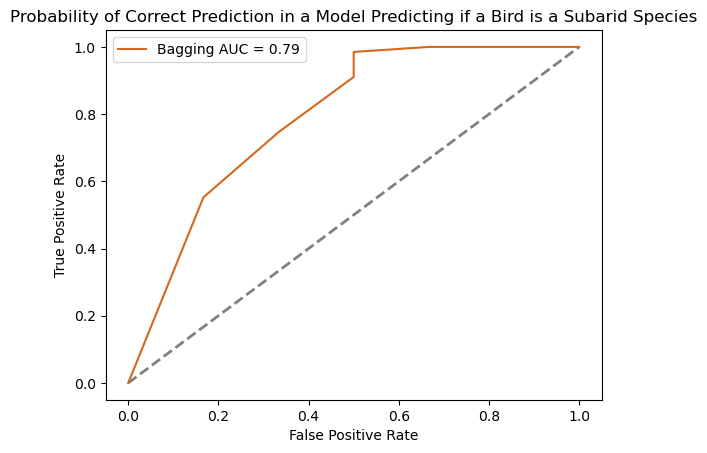

In [7]:
# generate probabilities of binary classification
bagging_probs = bagging.predict_proba(x_test)[:,1]

# get false positive and true positive rates
fpr, tpr, _ = roc_curve(y_test, bagging_probs)

# get area under curve
roc_auc_bagging = auc(fpr, tpr)

# make ROC graph
plt.plot([0,1], [0,1], linestyle = '--', color = 'grey', lw = 2)
plt.plot(fpr, tpr, label = f"Bagging AUC = {roc_auc_bagging:.2f}", color = 'chocolate')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Probability of Correct Prediction in a Model Predicting if a Bird is a Subarid Species')

Now how does the ROC curve look? How does this compare to our classification accuracy metric?  What might be going on? 

Our ROC is very jagged and irregular, and the AUC is much lower than the accuracy. This may be being caused by a class imbalance as a vast majority of birds in the dataset live in Subarid zones, with a ratio of about 8.7 : 1.

### Step 6: Introducing upsampling

The ROC curve indicates that our model is not performing well.  This is a common issue in imbalanced datasets, where one class significantly outnumbers the other. To improve our model’s ability to correctly classify both groups, we will upsample the minority class so that both classes have equal representation in the training set.

**Perform upsampling to balance the dataset**
1. Separate the majority and minority classes:
- Identify which class (0,1) is underrepresented (the minority class) and which is overrepresented (the majority class). 
- Separate both the `X_train` data and `y_train` data into all majority class and all minority class sets. 
2. Apply upsampling:
- Use `resample()` to create additional synthetic samples of the minority class *with replacement* until it is the same size as the majority class data. Use a random state of 808. 
3. Combine the balanced classes:
Merge the original majority class with the newly upsampled minority class.
4. Shuffle the resampled dataset:
- Randomly shuffle the data to ensure the model does not learn any unintended patterns from the order of the data. Use a random state of 808 for shuffling both the resampled X and y training data. 
5. Print the value counts for the resampled y training data to ensure that the data is balanced. 


In [8]:
# Separate majority and minority classes
maj_class = bird_traits_encoded[bird_traits_encoded['Subarid'] == 1]
min_class = bird_traits_encoded[bird_traits_encoded['Subarid'] == 0]

# separate dependant variable by majority/minority class
y_min = y_train[y_train == 0]
y_maj = y_train[y_train == 1]

# separate predictor variables by majority/minority class
x_min = x_train.loc[y_min.index]
x_maj = x_train.loc[y_maj.index]

# Upsample the minority class
y_min_resamp, x_min_resamp = resample(y_min, x_min, n_samples = len(y_maj), random_state = 808)

# Combine majority and upsampled minority class
y_upsampled = pd.concat([y_min_resamp, y_maj])
x_upsampled = pd.concat([x_min_resamp, x_maj])

# Shuffle the dataset
y_upsampled, x_upsampled = shuffle(y_upsampled, x_upsampled, random_state = 808)

# Print value counts 
print(f'Upsampled subarid variable value counts....\n\n{y_upsampled.value_counts()}')

Upsampled subarid variable value counts....

Subarid
1    150
0    150
Name: count, dtype: int64


### Step 7: Retrain and evaluate model using balanced data

Now that we have addressed the class imbalance by upsampling the minority class, we will retrain the bagging classifier on the newly balanced dataset and evaluate its performance. This will help us determine whether handling class imbalance improves model accuracy and its ability to distinguish between classes. Create a bagging model using your balanced data. Use a random state of 808. Print the accuracy and and ROC Curve for this new model with balanced data. 

In [9]:
# split data based on class balanced data
x_train_bal, x_test_bal, y_train_bal, y_test_bal = train_test_split(x_upsampled, y_upsampled, test_size = 0.3, random_state = 808)

# init bagging model with class balanced data
bagging_bal = BaggingClassifier(
                            oob_score = True,
                            bootstrap = True, 
                            random_state = 808
)

# retrain model
bagging_bal.fit(x_train_bal, y_train_bal)

/opt/anaconda3/envs/ml-env/lib/python3.10/site-packages/sklearn/ensemble/_bagging.py:789: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/opt/anaconda3/envs/ml-env/lib/python3.10/site-packages/sklearn/ensemble/_bagging.py:795: RuntimeWarning: invalid value encountered in divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]


BaggingClassifier(oob_score=True, random_state=808)

In [10]:
# get new predictions for class balanced model
bagging_bal_preds = bagging_bal.predict(x_test_bal)

print(f'OOB Score for upsampled and balanced bird traits bagging model: {bagging_bal.oob_score_}')
print(f'Accuracy for model: {accuracy_score(y_test_bal, bagging_bal_preds)}')

OOB Score for upsampled and balanced bird traits bagging model: 0.8523809523809524
Accuracy for model: 0.9444444444444444


Text(0.5, 1.0, 'Probability of Correct Prediction in a Model Predicting if a Bird is a Subarid Species')

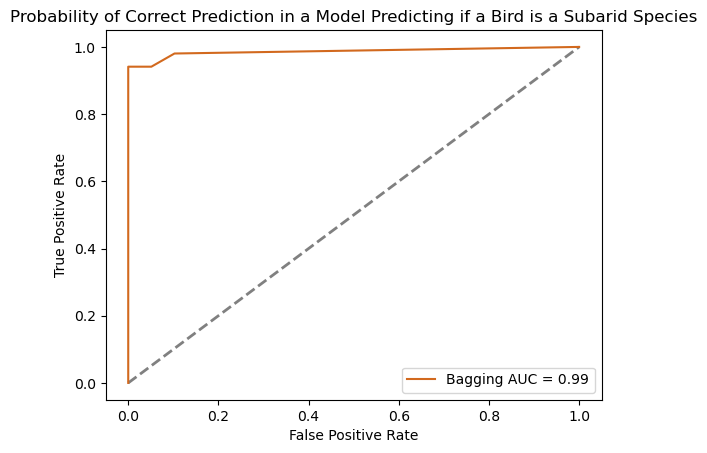

In [11]:
# get probabilities for binary classification
bagging_bal_probs = bagging_bal.predict_proba(x_test_bal)[:,1]

# get false positive rate and true positive rate
fpr_bal, tpr_bal, _ = roc_curve(y_test_bal, bagging_bal_probs)

# get area under curve
roc_auc_bagging_bal = auc(fpr_bal, tpr_bal)

# plot new AUC graph
plt.plot([0,1], [0,1], linestyle = '--', color = 'grey', lw = 2)
plt.plot(fpr_bal, tpr_bal, label = f"Bagging AUC = {roc_auc_bagging_bal:.2f}", color = 'chocolate')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Probability of Correct Prediction in a Model Predicting if a Bird is a Subarid Species')

How did this second model, trained on balanced data, do in comparison to the first on the accuracy and AUC metrics.  How should we interpret those results?  Did the upscaling prove useful?

The upscaled and balanced model is much more accurate than the first. By providing the model more data with the minority class by bootstrapping to bring the classes within equal margins, we allowed the model to gain better understanding of both classes, rather than becoming overtrained on the majority class.

### Step 8: Analyzing feature importance with permutation importance

Understanding which bird traits contribute the most to our model’s predictions is crucial for interpreting results. We covered in lecture how the results of ensemble methods are harder to interpret than a single decision tree.  But we do have some tools to do it.  In this step, we will compute permutation importance, which measures the impact of each trait by shuffling its values and observing the effect on model performance. This will help us identify which functional traits—such as diet, body mass, or habitat breadth—play the biggest role in predicting whether a species is found in a subarid environment.

Use `permutation_importance()` to calculate the importance values.  You'll need to pass it the model, the feature and target test data, and an n_repeats value of 10.

In [12]:
# get mean importance for each feature
importances = permutation_importance(bagging_bal, x_test, y_test, n_repeats = 10)['importances_mean']
# get std of mean importance
importances_std = permutation_importance(bagging_bal, x_test, y_test, n_repeats = 10)['importances_std']

# consolidate importance variables, sort, and print
bird_trait_importance = (pd.DataFrame(index = x.columns,
                                     data = {'Bird Trait Importance': importances, 
                                             'Std Dev.': importances_std})
                        .sort_values(by = 'Bird Trait Importance', 
                                     key = lambda x: abs(x), # sort by absolute value 
                                     ascending = False))

print(f'Importance of Traits for Identifying Birds from Subarid Habitats....\n\n{bird_trait_importance}')

Importance of Traits for Identifying Birds from Subarid Habitats....

                    Bird Trait Importance  Std Dev.
NestingHabit                     0.036986  0.020502
EggWidth                         0.026027  0.014754
MigratoryStatus                  0.024658  0.030753
IncubationTime                  -0.015068  0.017110
EggMass                         -0.015068  0.012630
Diet_Flowers                     0.012329  0.008219
ClutchSize                       0.012329  0.012252
Diet_Fruits                      0.010959  0.011379
AdultBodyMass                    0.006849  0.030012
Diet_Vertebrates                -0.006849  0.012555
DietBreadth                      0.005479  0.018833
EggLength                        0.005479  0.009189
MaxLongevity                     0.005479  0.011044
ActivityCycle                    0.004110  0.013422
ForagingStratum                  0.002740  0.000000
Diet_Seeds                      -0.001370  0.005479
Diet_Invertebrates               0.000000  0.0

What features are most important in our model of species distribution?

The top 10 features are...

1. Egg width
2. Migratory status
3. Nesting habit
4. Egg length
5. Diet of fruits
6. Egg mass
7. Clutch size
8. Incubation time
9. Diet of vertebrates
10. Diet flowers